<a href="https://colab.research.google.com/github/SharmilNK/XAI/blob/main/AdversarialPatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:lightning_fabric.utilities.seed:Seed set to 42


ipywidgets version: 7.7.1
tqdm backend: notebook
Using device cuda:0


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


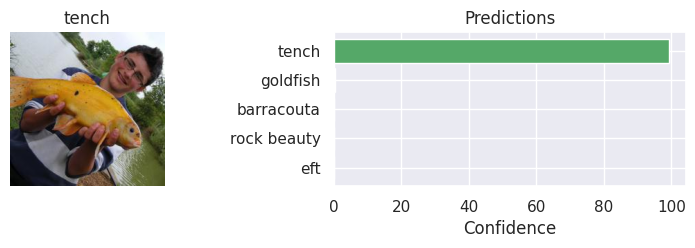

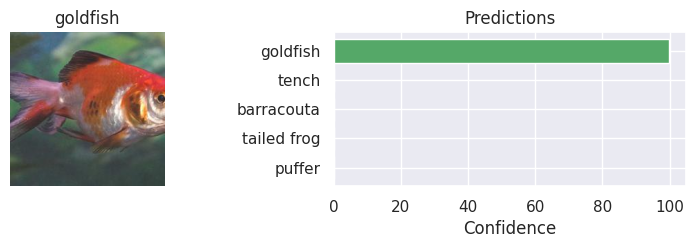

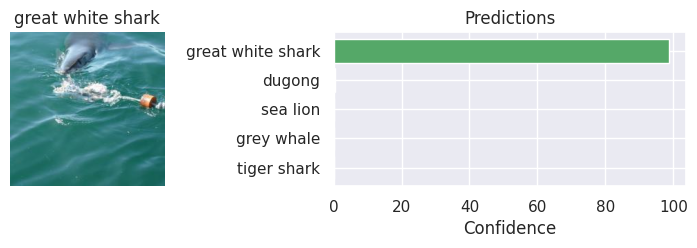

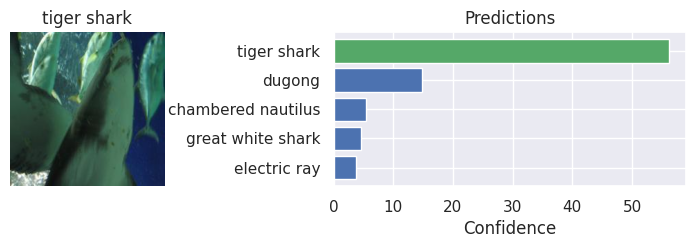

In [6]:
# === Original notebook code cells combined ===

'''! pip install numpy scipy matplotlib seaborn tqdm torch torchvision pytorch-lightning
! pip install -U jupyter ipywidgets tqdm
! pip install -U jupyterlab ipywidgets'''

# ---- original cell break ----

import ipywidgets
from ipywidgets import IntProgress
print("ipywidgets version:", ipywidgets.__version__)
IntProgress(value=42, min=0, max=100)

# ---- original cell break ----

try:
    # prefer notebook version (works in Colab / properly configured Jupyter)
    from tqdm.notebook import tqdm
    _TQDM_BACKEND = "notebook"
except Exception as e:
    # fallback to plain terminal version (always available)
    from tqdm import tqdm
    _TQDM_BACKEND = "console"

print("tqdm backend:", _TQDM_BACKEND)

# ---- original cell break ----

# common helpers
# Common utilities: PIL, torch, image conversions
from PIL import Image, ImageOps, ImageFilter, ImageDraw
import torch
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
import numpy as np
import os

def load_patch_image(path):
    """Load saved patch image into a PIL Image (RGB) and a torch tensor (C,H,W) in [0,1]."""
    pil = Image.open(path).convert("RGB")
    tensor = TF.to_tensor(pil)  # ranges [0,1]
    return pil, tensor

def save_pil(pil, path, dpi=300):
    """Save a PIL image. Specify dpi for print-ready files."""
    pil.save(path, dpi=(dpi, dpi))
    print("Saved:", path)

def tensor_to_pil(tensor):
    """Convert a torch tensor (C,H,W) in [0,1] to PIL."""
    return TF.to_pil_image(tensor.clamp(0,1))

def pil_to_tensor(pil):
    return TF.to_tensor(pil).clamp(0,1)


# ---- original cell break ----

## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.utils import save_image

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "C:/Users/som/Desktop/CourseSem1/XAI/AdversialAI/Duke-AI-XAI/adversarial-ai-example-notebooks/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "C:/Users/som/Desktop/CourseSem1/XAI/AdversialAI/Duke-AI-XAI/adversarial-ai-example-notebooks/models"

OUT_DIR = "C:/Users/som/Desktop/CourseSem1/XAI/AdversialAI/Duke-AI-XAI/adversarial-ai-example-notebooks/patch_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# ---- original cell break ----

import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

# ---- original cell break ----

# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

# ---- original cell break ----

# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

# ---- original cell break ----

def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    # use the previously imported tqdm (notebook or console)
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item() / counter
    top5 = tp_5.float().item() / counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):.2f}%")
    return acc, top5

# ---- original cell break ----

_ = eval_model(data_loader)

# ---- original cell break ----

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

# ---- original cell break ----

exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

# ---- original cell break ----

def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

# ---- original cell break ----

TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

# ---- original cell break ----

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

# ---- original cell break ----

def param_to_pixel(patch_param):
    # Accepts: nn.Parameter or Tensor in parameter space (unbounded) or pixel space.
    if isinstance(patch_param, torch.nn.Parameter) or (isinstance(patch_param, torch.Tensor) and patch_param.dtype.is_floating_point and (patch_param.min() < 0 or patch_param.max() > 1)):
        with torch.no_grad():
            pix = (torch.tanh(patch_param) + 1.0) / 2.0
    else:
        pix = patch_param.clone().detach() if isinstance(patch_param, torch.Tensor) else torch.tensor(patch_param, dtype=torch.float32)
    # If 3D with C first, leave as C,H,W; if H,W,C convert
    if pix.dim() == 3 and pix.shape[0] in (1,3):
        return pix
    if pix.dim() == 3 and pix.shape[2] in (1,3):
        # H,W,C -> convert
        return pix.permute(2,0,1)
    if pix.dim() == 2:
        # single channel H,W -> add channel dim
        return pix.unsqueeze(0)
    raise ValueError("Unsupported patch tensor shape: " + str(pix.shape))

# ---- original cell break ----

    def make_bubble_sticker(patch_tensor, output_size=800, border=12, gloss=True):
        """
        patch_tensor: torch tensor (3,H,W) in [0,1] OR PIL image
        output_size: output square size in pixels for printing
        border: border thickness in pixels
        gloss: add glossy highlight
        returns: PIL RGBA sticker image (transparent background)
        """
    if isinstance(patch_tensor, torch.Tensor):
        patch_pil = tensor_to_pil(patch_tensor)
    else:
        patch_pil = patch_tensor.convert("RGB")

    # Resize patch to fit inside circle
    inner_size = output_size - 2 * border
    patch_resized = patch_pil.resize((inner_size, inner_size), Image.BILINEAR)

    # Create RGBA base
    sticker = Image.new("RGBA", (output_size, output_size), (0,0,0,0))

    # Create circular mask (white inside circle)
    mask = Image.new("L", (output_size, output_size), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((border, border, output_size - border - 1, output_size - border - 1), fill=255)

    # Paste patch into sticker using mask for shape
    sticker.paste(patch_resized, (border, border), mask.crop((border,border,output_size-border,output_size-border)))

    # Optional: add soft white rim / stroke to simulate bubble rim
    rim = Image.new("RGBA", (output_size, output_size), (255,255,255,0))
    rim_draw = ImageDraw.Draw(rim)
    rim_draw.ellipse((border, border, output_size - border - 1, output_size - border - 1), outline=(255,255,255,80), width=6)
    sticker = Image.alpha_composite(sticker, rim)

    # Optional glossy highlight
    if gloss:
        gloss_mask = Image.new("L", (output_size, output_size), 0)
        gdraw = ImageDraw.Draw(gloss_mask)
        # elliptical highlight in top-left
        gdraw.ellipse((int(output_size*0.15), int(output_size*0.10), int(output_size*0.6), int(output_size*0.5)), fill=180)
        gloss_layer = Image.new("RGBA", (output_size, output_size), (255,255,255,0))
        gloss_layer.putalpha(gloss_mask)
        gloss_layer = gloss_layer.filter(ImageFilter.GaussianBlur(radius=10))
        sticker = Image.alpha_composite(sticker, gloss_layer)

    return sticker


# ---- original cell break ----

def make_cloud_sticker(patch_tensor, output_size=1000, margin=40):
    """
    Produce cloud-shaped sticker with patch inside the cloud cloud-body.
    returns PIL RGBA
    """
    if isinstance(patch_tensor, torch.Tensor):
        patch_pil = tensor_to_pil(patch_tensor)
    else:
        patch_pil = patch_tensor.convert("RGB")

    w = output_size; h = int(output_size * 0.7)
    # base cloud image (transparent)
    sticker = Image.new("RGBA", (w, h), (0,0,0,0))
    # create cloud mask by drawing overlapping circles
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)
    # a few circles positions (tweak for shape)
    circles = [
        (int(w*0.15), int(h*0.4), int(w*0.35), int(h*0.6)),
        (int(w*0.30), int(h*0.15), int(w*0.55), int(h*0.45)),
        (int(w*0.50), int(h*0.2), int(w*0.75), int(h*0.5)),
        (int(w*0.65), int(h*0.35), int(w*0.9), int(h*0.6)),
    ]
    for c in circles:
        draw.ellipse(c, fill=255)
    # draw bottom rectangle to form cloud base
    draw.rectangle((0, int(h*0.45), w, h), fill=255)

    # paste the patch inside the bounding box of mask
    bbox = mask.getbbox()
    inner_w = bbox[2] - bbox[0]
    inner_h = bbox[3] - bbox[1]
    patch_resized = patch_pil.resize((inner_w, inner_h), Image.BILINEAR)
    sticker.paste(patch_resized, (bbox[0], bbox[1]), patch_resized.convert("RGBA"))
    # apply mask to keep cloud outline
    sticker.putalpha(mask)
    # add soft white border
    rim = Image.new("RGBA", sticker.size, (255,255,255,0))
    rim_draw = ImageDraw.Draw(rim)
    rim_draw.ellipse((bbox[0]-8, bbox[1]-8, bbox[2]+8, bbox[3]+8), outline=(255,255,255,120), width=6)
    sticker = Image.alpha_composite(sticker, rim)
    return sticker


In [7]:
# Paste & run this cell before calling save_patch_and_stickers(...) or stamp_patch_on_examples_and_predict(...)

import os
import torch
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torchvision.transforms.functional as TF

# Config defaults (if your notebook already defines these, their values will be used)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NORM_MEAN = globals().get("NORM_MEAN", torch.tensor([0.485, 0.456, 0.406]))
NORM_STD  = globals().get("NORM_STD",  torch.tensor([0.229, 0.224, 0.225]))
OUT_DIR = globals().get("OUT_DIR", "patch_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Utility helpers (if you already have these, this will not clobber them) ----
def tensor_to_pil(tensor):
    if isinstance(tensor, torch.nn.Parameter):
        tensor = tensor.detach()
    t = tensor.clone().cpu()
    if t.dim() == 3 and t.shape[0] in (1,3):
        pass
    elif t.dim() == 3 and t.shape[2] in (1,3):
        t = t.permute(2,0,1)
    elif t.dim() == 2:
        t = t.unsqueeze(0)
    t = torch.clamp(t, 0.0, 1.0)
    return TF.to_pil_image(t)

def save_pil(pil, path, dpi=(300,300)):
    pil.save(path, dpi=dpi)

def param_to_pixel(patch_param):
    """Convert learned param (tanh parametrization) or pixel tensor to C,H,W pixel tensor in [0,1]."""
    if isinstance(patch_param, torch.nn.Parameter) or (isinstance(patch_param, torch.Tensor) and patch_param.dtype.is_floating_point and (patch_param.min() < 0 or patch_param.max() > 1)):
        with torch.no_grad():
            pix = (torch.tanh(patch_param) + 1.0) / 2.0
    else:
        pix = patch_param.clone().detach() if isinstance(patch_param, torch.Tensor) else torch.tensor(patch_param, dtype=torch.float32)
    # Normalize channel ordering to C,H,W
    if pix.dim() == 3 and pix.shape[0] in (1,3):
        return pix
    if pix.dim() == 3 and pix.shape[2] in (1,3):
        return pix.permute(2,0,1)
    if pix.dim() == 2:
        return pix.unsqueeze(0)
    raise ValueError("Unsupported patch tensor shape: " + str(pix.shape))

# ---- Define make_bubble_sticker (was missing) ----
def make_rounded_mask(size, radius):
    w,h = size
    mask = Image.new('L', (w,h), 0)
    draw = ImageDraw.Draw(mask)
    draw.rounded_rectangle([0,0,w,h], radius=radius, fill=255)
    return mask

def make_bubble_sticker(patch_pix, output_size=512, border=8, gloss=False):
    """
    Create a sticker-like rounded card with the patch centered.
    Returns PIL RGBA image.
    """
    pil_patch = tensor_to_pil(param_to_pixel(patch_pix).cpu())
    pad = border*4
    max_dim = output_size - pad
    # Resize patch to fit
    w_patch, h_patch = pil_patch.size
    scale = min(max_dim / max(w_patch, h_patch), 1.0)
    new_size = (max(1, int(w_patch*scale)), max(1, int(h_patch*scale)))
    pil_patch = pil_patch.resize(new_size, resample=Image.BILINEAR)
    w = h = output_size
    bg = Image.new('RGBA', (w,h), (255,255,255,0))
    mask = make_rounded_mask((w,h), radius=output_size//6)
    white_bg = Image.new('RGBA', (w,h), (255,255,255,255))
    # paste rounded white card
    bg.paste(white_bg, (0,0), mask)
    x = (w - pil_patch.size[0])//2
    y = (h - pil_patch.size[1])//2 - 8
    bg.paste(pil_patch.convert('RGBA'), (x,y), pil_patch.convert('RGBA'))
    if gloss:
        gloss_mask = Image.new('L', (w,h), 0)
        draw = ImageDraw.Draw(gloss_mask)
        draw.ellipse([w*0.1, h*0.05, w*0.9, h*0.4], fill=80)
        gloss_layer = Image.new('RGBA', (w,h), (255,255,255,0))
        gloss_layer.putalpha(gloss_mask)
        bg = Image.alpha_composite(bg, gloss_layer)
    return bg

# ---- Cloud sticker helper (unchanged) ----
def make_cloud_sticker(patch_pix, output_size=800, margin=40):
    pil_patch = tensor_to_pil(param_to_pixel(patch_pix).cpu())
    max_dim = output_size - margin*2
    pil_patch = pil_patch.resize((max_dim, max_dim), resample=Image.BILINEAR)
    w = h = output_size
    out = Image.new('RGBA', (w,h), (255,255,255,0))
    base = Image.new('RGBA', (w,h), (255,255,255,0))
    draw = ImageDraw.Draw(base)
    radii = [int(max_dim*0.35), int(max_dim*0.28), int(max_dim*0.22), int(max_dim*0.18), int(max_dim*0.14)]
    centers = [
        (w//2 - radii[0]//2, h//2),
        (w//2 + radii[1]//3, h//2 - radii[1]//4),
        (w//2, h//2 + radii[2]//3),
        (w//2 - radii[3], h//2 + radii[3]//4),
        (w//2 + radii[4], h//2 + radii[4]//3)
    ]
    for r,c in zip(radii, centers):
        draw.ellipse([c[0]-r, c[1]-r, c[0]+r, c[1]+r], fill=(255,255,255,255))
    base = base.filter(ImageFilter.GaussianBlur(radius=6))
    out = Image.alpha_composite(out, base)
    x = (w - pil_patch.size[0])//2
    y = (h - pil_patch.size[1])//2
    out.paste(pil_patch.convert('RGBA'), (x,y), pil_patch.convert('RGBA'))
    return out

# ---- Robust stamp + predict (replaces your previous stamp_patch_on_examples_and_predict) ----
def stamp_patch_on_examples_and_predict(patch_param,
                                        data_loader=None,
                                        pretrained_model=None,
                                        place_patch_fn=None,
                                        n_examples_to_save=8,
                                        out_dir=OUT_DIR,
                                        device=device,
                                        norm_mean=NORM_MEAN,
                                        norm_std=NORM_STD):
    """
    Safely stamp patch_param onto a batch and run preds.
    - patch_param: raw parameter (tanh-param) or pixel tensor (C,H,W)
    - data_loader, pretrained_model: will be pulled from globals if not passed
    - place_patch_fn: optional custom function to place patch (prefer to keep if you have one)
    """
    os.makedirs(out_dir, exist_ok=True)

    # Resolve globals if not given
    if data_loader is None:
        data_loader = globals().get("data_loader", None)
    if pretrained_model is None:
        pretrained_model = globals().get("pretrained_model", None)
    if place_patch_fn is None:
        place_patch_fn = globals().get("place_patch", None)

    if data_loader is None or pretrained_model is None:
        raise RuntimeError("data_loader and pretrained_model must be available in globals or passed in.")

    # get one batch
    batch_iter = iter(data_loader)
    try:
        imgs, labels = next(batch_iter)
    except Exception as e:
        raise RuntimeError("Failed to get a batch from data_loader: " + str(e))

    imgs = imgs.clone().float()  # normalized tensors expected by model
    bs = imgs.shape[0]

    # convert patch param -> pixel tensor C,H,W in [0,1]
    patch_pix = param_to_pixel(patch_param).cpu().clamp(0.0, 1.0)

    stamped = None

    # Strategy 1: use place_patch function if available (preferred)
    if place_patch_fn is not None:
        try:
            # try passing raw param first (training often used raw param), else pixel
            try:
                stamped = place_patch_fn(imgs.clone(), patch_param)
            except Exception:
                stamped = place_patch_fn(imgs.clone(), patch_pix)
            if not isinstance(stamped, torch.Tensor):
                # ensure we have tensor
                raise RuntimeError("place_patch returned non-tensor")
        except Exception:
            stamped = None

    # Strategy 2: manual pasting -> guarantee stamped is created
    if stamped is None:
        pil_patch = tensor_to_pil(patch_pix)
        pil_ims = []
        mean = norm_mean.cpu().numpy()
        std  = norm_std.cpu().numpy()

        for i in range(bs):
            img_t = imgs[i].cpu()
            img_unnorm = img_t * torch.tensor(std).view(-1,1,1) + torch.tensor(mean).view(-1,1,1)
            img_unnorm = torch.clamp(img_unnorm, 0.0, 1.0)
            img_pil = TF.to_pil_image(img_unnorm)
            iw, ih = img_pil.size

            # resize patch to fit
            pw, ph = pil_patch.size
            if pw >= iw or ph >= ih:
                scale = min((iw-4)/pw, (ih-4)/ph, 1.0)
                new_w = max(1, int(pw*scale))
                new_h = max(1, int(ph*scale))
                curr_patch = pil_patch.resize((new_w, new_h), resample=Image.BILINEAR)
            else:
                curr_patch = pil_patch

            # place patch at center (deterministic)
            x = (iw - curr_patch.size[0]) // 2
            y = (ih - curr_patch.size[1]) // 2

            # if RGBA patch, use its alpha; else paste directly
            if curr_patch.mode in ("RGBA", "LA") or ("transparency" in curr_patch.info):
                img_pil.paste(curr_patch, (x, y), curr_patch.convert("RGBA"))
            else:
                img_pil.paste(curr_patch, (x, y))

            pil_ims.append(img_pil)

        # convert back to tensor and normalize
        stamped_tensors = []
        for p in pil_ims:
            t = TF.to_tensor(p).float()  # 0..1
            t = TF.normalize(t, mean=norm_mean.tolist(), std=norm_std.tolist())
            stamped_tensors.append(t)
        stamped = torch.stack(stamped_tensors, dim=0)

    # final safety check
    if stamped is None or not isinstance(stamped, torch.Tensor):
        raise RuntimeError("Could not create stamped tensor (stamped is None or not a tensor)")

    # move to device and run model
    stamped = stamped.to(device)
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    with torch.no_grad():
        preds = pretrained_model(stamped)

    # save first n images (unnormalize back to pixel)
    nsave = min(n_examples_to_save, stamped.shape[0])
    for i in range(nsave):
        img_t = stamped[i].cpu()
        img_unnorm = img_t * norm_std.view(-1,1,1) + norm_mean.view(-1,1,1)
        img_unnorm = torch.clamp(img_unnorm, 0.0, 1.0)
        pil = TF.to_pil_image(img_unnorm)
        path = os.path.join(out_dir, f"stamped_example_{i}.png")
        pil.save(path, dpi=(300,300))
        # print top predictions
        try:
            probs = torch.softmax(preds[i], dim=0)
            topk = torch.topk(probs, k=min(5, probs.numel()))
            tops = list(zip(topk.indices.cpu().tolist(), topk.values.cpu().tolist()))
            print(f"Saved {path}; top predictions (idx,prob): {tops}")
        except Exception:
            print(f"Saved {path}; raw pred: {preds[i].cpu().numpy()}")

    return preds

# Helpful note: if your DataLoader warns about many workers, reduce num_workers (example below)
try:
    # If your loader is named 'data_loader', try to lower workers to 2 for stability:
    if 'data_loader' in globals() and hasattr(globals()['data_loader'], 'num_workers'):
        try:
            globals()['data_loader'].num_workers = min(getattr(globals()['data_loader'], 'num_workers', 2), 2)
        except Exception:
            pass
except Exception:
    pass

print("Fixed helpers loaded: make_bubble_sticker defined; stamp_patch_on_examples_and_predict replaced (robust).")


Fixed helpers loaded: make_bubble_sticker defined; stamp_patch_on_examples_and_predict replaced (robust).


In [10]:
# === Paste-replace: robust save_patch_and_stickers, stamp_patch_on_examples_and_predict, perform_patch_attack ===
import os
import torch
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torchvision.transforms.functional as TF

# Helper fallbacks (won't overwrite if you already defined them)
def _ensure_tensor_to_pil():
    if 'tensor_to_pil' in globals():
        return globals()['tensor_to_pil']
    def tensor_to_pil(tensor):
        if isinstance(tensor, torch.nn.Parameter):
            tensor = tensor.detach()
        t = tensor.clone().cpu()
        if t.dim() == 3 and t.shape[0] in (1,3):
            pass
        elif t.dim() == 3 and t.shape[2] in (1,3):
            t = t.permute(2,0,1)
        elif t.dim() == 2:
            t = t.unsqueeze(0)
        t = torch.clamp(t, 0.0, 1.0)
        return TF.to_pil_image(t)
    globals()['tensor_to_pil'] = tensor_to_pil
    return tensor_to_pil

def _ensure_save_pil():
    if 'save_pil' in globals():
        return globals()['save_pil']
    def save_pil(pil, path, dpi=(300,300)):
        pil.save(path, dpi=dpi)
    globals()['save_pil'] = save_pil
    return save_pil

def _ensure_param_to_pixel():
    if 'param_to_pixel' in globals():
        return globals()['param_to_pixel']
    def param_to_pixel(patch_param):
        if isinstance(patch_param, torch.nn.Parameter) or (isinstance(patch_param, torch.Tensor) and patch_param.dtype.is_floating_point and (patch_param.min() < 0 or patch_param.max() > 1)):
            with torch.no_grad():
                pix = (torch.tanh(patch_param) + 1.0) / 2.0
        else:
            pix = patch_param.clone().detach() if isinstance(patch_param, torch.Tensor) else torch.tensor(patch_param, dtype=torch.float32)
        if pix.dim() == 3 and pix.shape[0] in (1,3):
            return pix
        if pix.dim() == 3 and pix.shape[2] in (1,3):
            return pix.permute(2,0,1)
        if pix.dim() == 2:
            return pix.unsqueeze(0)
        raise ValueError("Unsupported patch tensor shape: " + str(pix.shape))
    globals()['param_to_pixel'] = param_to_pixel
    return param_to_pixel

# create bubble sticker fallback if user didn't define one
def _ensure_make_bubble():
    if 'make_bubble_sticker' in globals():
        return globals()['make_bubble_sticker']
    def make_bubble_sticker(patch_pix, output_size=512, border=8, gloss=False):
        pil_patch = tensor_to_pil(param_to_pixel(patch_pix).cpu())
        pad = border*4
        max_dim = output_size - pad
        w_patch, h_patch = pil_patch.size
        scale = min(max_dim / max(w_patch, h_patch), 1.0)
        new_size = (max(1, int(w_patch*scale)), max(1, int(h_patch*scale)))
        pil_patch = pil_patch.resize(new_size, resample=Image.BILINEAR)
        w = h = output_size
        bg = Image.new('RGBA', (w,h), (255,255,255,0))
        # rounded rectangle mask
        mask = Image.new('L', (w,h), 0)
        draw = ImageDraw.Draw(mask)
        draw.rounded_rectangle([0,0,w,h], radius=output_size//6, fill=255)
        white_bg = Image.new('RGBA', (w,h), (255,255,255,255))
        bg.paste(white_bg, (0,0), mask)
        x = (w - pil_patch.size[0])//2
        y = (h - pil_patch.size[1])//2 - 8
        bg.paste(pil_patch.convert('RGBA'), (x,y), pil_patch.convert('RGBA'))
        if gloss:
            gloss_mask = Image.new('L', (w,h), 0)
            draw = ImageDraw.Draw(gloss_mask)
            draw.ellipse([w*0.1, h*0.05, w*0.9, h*0.4], fill=80)
            gloss_layer = Image.new('RGBA', (w,h), (255,255,255,0))
            gloss_layer.putalpha(gloss_mask)
            bg = Image.alpha_composite(bg, gloss_layer)
        return bg
    globals()['make_bubble_sticker'] = make_bubble_sticker
    return make_bubble_sticker

def _ensure_make_cloud():
    if 'make_cloud_sticker' in globals():
        return globals()['make_cloud_sticker']
    def make_cloud_sticker(patch_pix, output_size=800, margin=40):
        pil_patch = tensor_to_pil(param_to_pixel(patch_pix).cpu())
        max_dim = output_size - margin*2
        pil_patch = pil_patch.resize((max_dim, max_dim), resample=Image.BILINEAR)
        w = h = output_size
        out = Image.new('RGBA', (w,h), (255,255,255,0))
        base = Image.new('RGBA', (w,h), (255,255,255,0))
        draw = ImageDraw.Draw(base)
        radii = [int(max_dim*0.35), int(max_dim*0.28), int(max_dim*0.22), int(max_dim*0.18), int(max_dim*0.14)]
        centers = [(w//2 - radii[0]//2, h//2), (w//2 + radii[1]//3, h//2 - radii[1]//4), (w//2, h//2 + radii[2]//3),
                   (w//2 - radii[3], h//2 + radii[3]//4), (w//2 + radii[4], h//2 + radii[4]//3)]
        for r,c in zip(radii, centers):
            draw.ellipse([c[0]-r, c[1]-r, c[0]+r, c[1]+r], fill=(255,255,255,255))
        base = base.filter(ImageFilter.GaussianBlur(radius=6))
        out = Image.alpha_composite(out, base)
        x = (w - pil_patch.size[0])//2
        y = (h - pil_patch.size[1])//2
        out.paste(pil_patch.convert('RGBA'), (x,y), pil_patch.convert('RGBA'))
        return out
    globals()['make_cloud_sticker'] = make_cloud_sticker
    return make_cloud_sticker

# ensure helpers exist
tensor_to_pil = _ensure_tensor_to_pil()
save_pil = _ensure_save_pil()
param_to_pixel = _ensure_param_to_pixel()
make_bubble_sticker = _ensure_make_bubble()
make_cloud_sticker = _ensure_make_cloud()

# use globals for config if available
OUT_DIR = globals().get('OUT_DIR', 'patch_outputs')
os.makedirs(OUT_DIR, exist_ok=True)
device = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
NORM_MEAN = globals().get('NORM_MEAN', torch.tensor([0.485,0.456,0.406]))
NORM_STD  = globals().get('NORM_STD',  torch.tensor([0.229,0.224,0.225]))

# ---------- Replacement save_patch_and_stickers ----------
def save_patch_and_stickers(patch_dict, out_dir=OUT_DIR, make_bubble=True, make_cloud=True):
    """Iterate patch_dict[class][size]['patch'] and save patch PNG + bubble/cloud stickers."""
    for cname in patch_dict:
        for psize, info in patch_dict[cname].items():
            p = info.get("patch", None)
            if p is None:
                print("No patch for", cname, psize)
                continue
            try:
                pixel = param_to_pixel(p)  # C,H,W in [0,1]
            except Exception as e:
                print("Failed converting patch to pixel for", cname, psize, ":", e)
                continue

            pil_patch = tensor_to_pil(pixel.cpu())

            # Save raw patch (square) as PNG
            base_name = f"{cname}_patch_{psize}"
            patch_path = os.path.join(out_dir, base_name + ".png")
            try:
                save_pil(pil_patch, patch_path, dpi=(300, 300))
                print("Saved:", patch_path)
            except Exception as e:
                print("Failed saving patch PNG for", base_name, ":", e)

            # Make and save bubble sticker
            if make_bubble:
                try:
                    bubble = make_bubble_sticker(pixel, output_size=800, border=12, gloss=True)
                    bubble_path = os.path.join(out_dir, base_name + "_bubble.png")
                    bubble.save(bubble_path, dpi=(300,300))
                    print("Saved bubble:", bubble_path)
                except Exception as e:
                    print("Failed creating bubble for", base_name, ":", e)

            # Make and save cloud sticker
            if make_cloud:
                try:
                    cloud = make_cloud_sticker(pixel, output_size=1200, margin=40)
                    cloud_path = os.path.join(out_dir, base_name + "_cloud.png")
                    cloud.save(cloud_path, dpi=(300,300))
                    print("Saved cloud:", cloud_path)
                except Exception as e:
                    print("Failed creating cloud for", base_name, ":", e)

# ---------- Replacement stamp function (defensive) ----------
def stamp_patch_on_examples_and_predict(patch_param,
                                        data_loader=None,
                                        pretrained_model=None,
                                        place_patch_fn=None,
                                        n_examples_to_save=8,
                                        out_dir=OUT_DIR):
    # Resolve from globals if not provided
    data_loader = data_loader if data_loader is not None else globals().get('data_loader', None)
    pretrained_model = pretrained_model if pretrained_model is not None else globals().get('pretrained_model', None)
    place_patch_fn = place_patch_fn if place_patch_fn is not None else globals().get('place_patch', None)

    if data_loader is None or pretrained_model is None:
        raise RuntimeError("data_loader and pretrained_model are required (pass them or run original code).")

    # get one batch
    try:
        ex_iter = iter(data_loader)
        ex_batch, label_batch = next(ex_iter)
    except Exception as e:
        raise RuntimeError("Failed to obtain a sample batch from data_loader: " + str(e))

    imgs = ex_batch.clone().float()
    bs = imgs.shape[0]

    # convert patch param -> pixel tensor C,H,W in [0,1]
    patch_pix = param_to_pixel(patch_param).cpu().clamp(0.0, 1.0)

    stamped = None

    # Try to use place_patch (preferred)
    if place_patch_fn is not None:
        try:
            # some implementations expect raw param, others pixels; try both
            try:
                stamped = place_patch_fn(imgs.clone(), patch_param)
            except Exception:
                stamped = place_patch_fn(imgs.clone(), patch_pix)
            if not isinstance(stamped, torch.Tensor):
                raise RuntimeError("place_patch returned non-tensor")
        except Exception as e:
            # fallback below
            print("place_patch failed or incompatible; falling back to PIL paste. (Error:", e, ")")
            stamped = None

    # Manual deterministic paste fallback (center)
    if stamped is None:
        pil_patch = tensor_to_pil(patch_pix)
        pil_list = []
        mean = NORM_MEAN.cpu().numpy() if isinstance(NORM_MEAN, torch.Tensor) else np.array(NORM_MEAN)
        std  = NORM_STD.cpu().numpy() if isinstance(NORM_STD, torch.Tensor) else np.array(NORM_STD)

        for i in range(bs):
            img_t = imgs[i].cpu()
            img_unnorm = img_t * torch.tensor(std).view(-1,1,1) + torch.tensor(mean).view(-1,1,1)
            img_unnorm = torch.clamp(img_unnorm, 0.0, 1.0)
            img_pil = TF.to_pil_image(img_unnorm)

            iw, ih = img_pil.size
            pw, ph = pil_patch.size
            if pw >= iw or ph >= ih:
                scale = min((iw - 4) / pw, (ih - 4) / ph, 1.0)
                curr_patch = pil_patch.resize((max(1, int(pw*scale)), max(1, int(ph*scale))), resample=Image.BILINEAR)
            else:
                curr_patch = pil_patch

            x = (iw - curr_patch.size[0]) // 2
            y = (ih - curr_patch.size[1]) // 2

            # If RGBA patch, use alpha; else paste overwriting
            if curr_patch.mode in ("RGBA", "LA") or ("transparency" in curr_patch.info):
                img_pil.paste(curr_patch, (x, y), curr_patch.convert("RGBA"))
            else:
                img_pil.paste(curr_patch, (x, y))
            pil_list.append(img_pil)

        # convert back and normalize
        stamped_tensors = []
        for pil in pil_list:
            t = TF.to_tensor(pil).float()  # 0..1
            t = TF.normalize(t, mean=NORM_MEAN.tolist(), std=NORM_STD.tolist())
            stamped_tensors.append(t)
        stamped = torch.stack(stamped_tensors, dim=0)

    # final safety check
    if stamped is None or not isinstance(stamped, torch.Tensor):
        raise RuntimeError("Could not create stamped tensor.")

    # Move to device
    stamped = stamped.to(device)
    model = pretrained_model.to(device)
    model.eval()

    with torch.no_grad():
        preds = model(stamped)

    # Save and print results for first n examples
    nsave = min(n_examples_to_save, stamped.shape[0])
    for i in range(nsave):
        img_t = stamped[i].cpu()
        img_unnorm = img_t * NORM_STD.view(-1,1,1) + NORM_MEAN.view(-1,1,1)
        img_unnorm = torch.clamp(img_unnorm, 0.0, 1.0)
        pil = TF.to_pil_image(img_unnorm)
        out_path = os.path.join(out_dir, f"stamped_example_{i}.png")
        pil.save(out_path, dpi=(300,300))
        # Print top-k preds if possible
        try:
            probs = torch.softmax(preds[i], dim=0)
            topk = torch.topk(probs, k=min(5, probs.numel()))
            print(f"Saved {out_path}; top preds (idx,prob):", list(zip(topk.indices.cpu().tolist(), topk.values.cpu().tolist())))
        except Exception:
            print("Saved", out_path, "; raw pred:", preds[i].cpu().numpy())

    return preds, (ex_batch, label_batch)

# ---------- Replacement perform_patch_attack (safe) ----------
def perform_patch_attack(patch):
    """
    Uses available example batch (exmp_batch,label_batch) if present,
    otherwise pulls one minibatch from data_loader. Shows predictions.
    """
    # Find an example batch
    ex_batch = globals().get('exmp_batch', None)
    label_batch = globals().get('label_batch', None)
    if ex_batch is None or label_batch is None:
        # try pulling from data_loader
        dl = globals().get('data_loader', None)
        if dl is None:
            raise RuntimeError("No example batch (exmp_batch) and data_loader not available.")
        ex_batch, label_batch = next(iter(dl))

    # place patch using place_patch if available
    place_patch_fn = globals().get('place_patch', None)
    if place_patch_fn is not None:
        try:
            patched_batch = place_patch_fn(ex_batch.clone(), patch)
        except Exception:
            patched_batch = ex_batch.clone()
            print("place_patch failed in perform_patch_attack; using original images.")
    else:
        # fallback: manual paste using same center-deterministic approach
        pil_patch = tensor_to_pil(param_to_pixel(patch).cpu())
        patched_pils = []
        for i in range(ex_batch.shape[0]):
            img_t = ex_batch[i].cpu()
            img_unnorm = img_t * NORM_STD.view(-1,1,1) + NORM_MEAN.view(-1,1,1)
            img_pil = TF.to_pil_image(torch.clamp(img_unnorm,0,1))
            iw, ih = img_pil.size
            pw, ph = pil_patch.size
            if pw >= iw or ph >= ih:
                scale = min((iw - 4) / pw, (ih - 4) / ph, 1.0)
                curr_patch = pil_patch.resize((max(1,int(pw*scale)), max(1,int(ph*scale))))
            else:
                curr_patch = pil_patch
            x = (iw - curr_patch.size[0]) // 2
            y = (ih - curr_patch.size[1]) // 2
            if curr_patch.mode in ("RGBA", "LA") or ("transparency" in curr_patch.info):
                img_pil.paste(curr_patch, (x,y), curr_patch.convert("RGBA"))
            else:
                img_pil.paste(curr_patch, (x,y))
            patched_pils.append(img_pil)
        # convert back to tensor and normalize
        patched_tensors = []
        for p in patched_pils:
            t = TF.to_tensor(p).float()
            t = TF.normalize(t, mean=NORM_MEAN.tolist(), std=NORM_STD.tolist())
            patched_tensors.append(t)
        patched_batch = torch.stack(patched_tensors).to(next(globals()['pretrained_model'].parameters()).device)

    # predict and show some examples (uses show_prediction if available)
    with torch.no_grad():
        preds = globals()['pretrained_model'](patched_batch.to(device))
    show_fn = globals().get('show_prediction', None)
    if show_fn is None:
        # As fallback, just print top-1 class index for first few
        probs = torch.softmax(preds, dim=1)
        top1 = torch.argmax(probs, dim=1)
        for i in range(min(8, patched_batch.shape[0])):
            print(f"Example {i} top1:", int(top1[i].cpu().item()))
    else:
        for i in range(0, min(16, patched_batch.shape[0]), 5):
            try:
                show_fn(patched_batch[i].cpu(), label_batch[i], preds[i])
            except Exception as e:
                print("show_prediction failed for index", i, ":", e)

# === End of replacement functions ===


In [11]:
# === Cleaned imports and configuration ===
import os
import json
import torch
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

torch.set_num_threads(2)
class_names = ['umbrella']
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])
OUT_DIR = 'patch_outputs'
os.makedirs(OUT_DIR, exist_ok=True)


In [12]:
def tensor_to_pil(tensor):
    if isinstance(tensor, torch.nn.Parameter):
        tensor = tensor.detach()
    t = tensor.clone().cpu()
    if t.dim() == 3 and t.shape[0] in (1,3):
        t = t
    elif t.dim() == 3 and t.shape[2] in (1,3):
        t = t.permute(2,0,1)
    elif t.dim() == 2:
        t = t.unsqueeze(0)
    t = torch.clamp(t, 0.0, 1.0)
    return TF.to_pil_image(t)

def save_pil(pil, path, dpi=(300,300)):
    pil.save(path, dpi=dpi)

def param_to_pixel(patch_param):
    if isinstance(patch_param, torch.nn.Parameter) or (isinstance(patch_param, torch.Tensor) and patch_param.dtype.is_floating_point and (patch_param.min() < 0 or patch_param.max() > 1)):
        with torch.no_grad():
            pix = (torch.tanh(patch_param) + 1.0) / 2.0
    else:
        pix = patch_param.clone().detach() if isinstance(patch_param, torch.Tensor) else torch.tensor(patch_param, dtype=torch.float32)
    if pix.dim() == 3 and pix.shape[0] in (1,3):
        return pix
    if pix.dim() == 3 and pix.shape[2] in (1,3):
        return pix.permute(2,0,1)
    if pix.dim() == 2:
        return pix.unsqueeze(0)
    raise ValueError('Unsupported patch tensor shape: ' + str(pix.shape))


In [13]:
def show_patches(patch_dict, class_names, patch_sizes):
    nrows = len(patch_sizes)
    ncols = len(class_names)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2.2, nrows * 2.2))
    if isinstance(axes, plt.Axes):
        axes = np.array([[axes]])
    else:
        axes = np.array(axes)
        if axes.ndim == 1:
            if nrows == 1:
                axes = axes.reshape(1, ncols)
            elif ncols == 1:
                axes = axes.reshape(nrows, 1)
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            ax = axes[p_idx, c_idx]
            try:
                patch_param = patch_dict[cname][psize]['patch']
            except Exception:
                ax.set_title(f"{cname} {psize}\n(missing)")
                ax.axis('off')
                continue
            try:
                patch_pix = param_to_pixel(patch_param)
            except Exception:
                ax.set_title(f"{cname} {psize}\n(invalid)")
                ax.axis('off')
                continue
            if patch_pix.dim() == 3:
                patch_np = patch_pix.cpu().permute(1,2,0).numpy()
            else:
                patch_np = patch_pix.cpu().numpy()
            patch_np = np.clip(patch_np, 0.0, 1.0)
            if patch_np.ndim == 2 or (patch_np.ndim == 3 and patch_np.shape[2] == 1):
                ax.imshow(patch_np.squeeze(), cmap='gray', vmin=0, vmax=1)
            else:
                ax.imshow(patch_np, vmin=0, vmax=1)
            ax.set_title(f"{cname}, size {psize}")
            ax.axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()


In [14]:
def make_rounded_mask(size, radius):
    w,h = size
    mask = Image.new('L', (w,h), 0)
    draw = ImageDraw.Draw(mask)
    draw.rounded_rectangle([0,0,w,h], radius=radius, fill=255)
    return mask

def make_bubble_sticker(patch_pix, output_size=512, border=8, gloss=False):
    pil = tensor_to_pil(param_to_pixel(patch_pix).cpu())
    pad = border*4
    max_dim = output_size - pad
    pil = pil.resize((max_dim, max_dim), resample=Image.BILINEAR)
    w = h = output_size
    bg = Image.new('RGBA', (w,h), (255,255,255,0))
    mask = make_rounded_mask((w,h), radius=output_size//6)
    white_bg = Image.new('RGBA', (w,h), (255,255,255,255))
    bg.paste(white_bg, (0,0), mask)
    x = (w - pil.size[0])//2
    y = (h - pil.size[1])//2 - 10
    bg.paste(pil.convert('RGBA'), (x,y), pil.convert('RGBA'))
    if gloss:
        gloss_mask = Image.new('L', (w,h), 0)
        draw = ImageDraw.Draw(gloss_mask)
        draw.ellipse([w*0.1, h*0.05, w*0.9, h*0.4], fill=80)
        gloss_layer = Image.new('RGBA', (w,h), (255,255,255,0))
        gloss_layer.putalpha(gloss_mask)
        bg = Image.alpha_composite(bg, gloss_layer)
    return bg

def make_cloud_sticker(patch_pix, output_size=800, margin=40):
    pil = tensor_to_pil(param_to_pixel(patch_pix).cpu())
    max_dim = output_size - margin*2
    pil = pil.resize((max_dim, max_dim), resample=Image.BILINEAR)
    w = h = output_size
    out = Image.new('RGBA', (w,h), (255,255,255,0))
    base = Image.new('RGBA', (w,h), (255,255,255,0))
    draw = ImageDraw.Draw(base)
    radii = [int(max_dim*0.35), int(max_dim*0.28), int(max_dim*0.22), int(max_dim*0.18), int(max_dim*0.14)]
    centers = [(w//2 - radii[0]//2, h//2), (w//2 + radii[1]//3, h//2 - radii[1]//4), (w//2, h//2 + radii[2]//3), (w//2 - radii[3], h//2 + radii[3]//4), (w//2 + radii[4], h//2 + radii[4]//3)]
    for r,c in zip(radii, centers):
        draw.ellipse([c[0]-r, c[1]-r, c[0]+r, c[1]+r], fill=(255,255,255,255))
    base = base.filter(ImageFilter.GaussianBlur(radius=6))
    out = Image.alpha_composite(out, base)
    x = (w - pil.size[0])//2
    y = (h - pil.size[1])//2
    out.paste(pil.convert('RGBA'), (x,y), pil.convert('RGBA'))
    return out


In [15]:
def save_patch_and_make_stickers(patch_dict, out_dir=OUT_DIR):
    for cname in patch_dict:
        for psize, info in patch_dict[cname].items():
            p = info.get('patch')
            if p is None:
                print('No patch found for', cname, psize)
                continue
            try:
                pix = param_to_pixel(p)
            except Exception as e:
                print('Failed converting patch for', cname, psize, e)
                continue
            pil_patch = tensor_to_pil(pix.cpu())
            fname = os.path.join(out_dir, f"{cname}_patch_{psize}.png")
            save_pil(pil_patch, fname)
            print('Saved:', fname)
            try:
                bub = make_bubble_sticker(pix, output_size=800, border=12, gloss=True)
                bub.save(os.path.join(out_dir, f"{cname}_patch_{psize}_bubble.png"))
                print('Saved bubble:', os.path.join(out_dir, f"{cname}_patch_{psize}_bubble.png"))
            except Exception as e:
                print('Failed bubble for', cname, psize, e)
            try:
                cl = make_cloud_sticker(pix, output_size=1000)
                cl.save(os.path.join(out_dir, f"{cname}_patch_{psize}_cloud.png"))
                print('Saved cloud:', os.path.join(out_dir, f"{cname}_patch_{psize}_cloud.png"))
            except Exception as e:
                print('Failed cloud for', cname, psize, e)
try:
    save_patch_and_make_stickers(patch_dict)
except Exception as e:
    print('Could not save patches/stickers automatically - ensure patch_dict exists and rerun this cell:', e)


Saved: patch_outputs/umbrella_patch_32.png
Saved bubble: patch_outputs/umbrella_patch_32_bubble.png
Saved cloud: patch_outputs/umbrella_patch_32_cloud.png
Saved: patch_outputs/umbrella_patch_48.png
Saved bubble: patch_outputs/umbrella_patch_48_bubble.png
Saved cloud: patch_outputs/umbrella_patch_48_cloud.png
Saved: patch_outputs/umbrella_patch_64.png
Saved bubble: patch_outputs/umbrella_patch_64_bubble.png
Saved cloud: patch_outputs/umbrella_patch_64_cloud.png


In [16]:
def stamp_and_predict(patch_param, n_examples=8, out_dir=OUT_DIR):
    try:
        dl = globals().get('data_loader', None)
        model = globals().get('pretrained_model', None)
        if dl is None or model is None:
            raise RuntimeError('data_loader or pretrained_model not found in globals; run original code cell first')
    except Exception as e:
        print('Error:', e)
        return
    helper = globals().get('stamp_patch_on_examples_and_predict', None)
    if helper is not None:
        print('Using helper stamp_patch_on_examples_and_predict from globals (if defined)')
        return helper(patch_param, data_loader=dl, pretrained_model=model, n_examples_to_save=n_examples, out_dir=out_dir)
    batch_iter = iter(dl)
    images, labels = next(batch_iter)
    images = images.clone().float()
    bs = images.shape[0]
    pix = param_to_pixel(patch_param)
    pil_patch = tensor_to_pil(pix.cpu())
    saved = []
    for i in range(min(n_examples, bs)):
        img_t = images[i]
        mean = NORM_MEAN.view(-1,1,1)
        std = NORM_STD.view(-1,1,1)
        img_unnorm = img_t * std + mean
        img_unnorm = torch.clamp(img_unnorm, 0.0, 1.0)
        img_pil = TF.to_pil_image(img_unnorm)
        iw, ih = img_pil.size
        pw, ph = pil_patch.size
        if pw >= iw or ph >= ih:
            scale = min((iw-4)/pw, (ih-4)/ph, 1.0)
            pil_use = pil_patch.resize((max(1,int(pw*scale)), max(1,int(ph*scale))))
        else:
            pil_use = pil_patch
        x = (iw - pil_use.size[0])//2
        y = (ih - pil_use.size[1])//2
        img_pil.paste(pil_use, (x,y), pil_use.convert('RGBA'))
        t = TF.to_tensor(img_pil)
        t = TF.normalize(t, mean=NORM_MEAN.tolist(), std=NORM_STD.tolist())
        saved.append(t)
    stamped = torch.stack(saved).to(next(model.parameters()).device)
    with torch.no_grad():
        preds = model(stamped)
    for i in range(stamped.shape[0]):
        img_t = stamped[i].cpu()
        img_unnorm = img_t * NORM_STD.view(-1,1,1) + NORM_MEAN.view(-1,1,1)
        pil = TF.to_pil_image(torch.clamp(img_unnorm,0,1))
        path = os.path.join(out_dir, f'stamped_fallback_{i}.png')
        pil.save(path, dpi=(300,300))
        print('Saved fallback stamped image:', path)
    return preds
try:
    patch_param = patch_dict['umbrella'][48]['patch']
except Exception:
    try:
        any_c = next(iter(patch_dict))
        any_sz = next(iter(patch_dict[any_c]))
        patch_param = patch_dict[any_c][any_sz]['patch']
    except Exception:
        patch_param = None
if patch_param is not None:
    try:
        preds = stamp_and_predict(patch_param, n_examples=4)
        print('Predictions shape:', getattr(preds, 'shape', 'unknown'))
    except Exception as e:
        print('Could not run stamping/prediction:', e)
else:
    print('No patch_param found; run the original code cell to generate patch_dict and rerun this cell')


Using helper stamp_patch_on_examples_and_predict from globals (if defined)
Saved patch_outputs/stamped_example_0.png; top preds (idx,prob): [(879, 0.9831928014755249), (701, 0.01221256423741579), (672, 0.002941665006801486), (723, 0.0010927561670541763), (325, 8.759077900322154e-05)]
Saved patch_outputs/stamped_example_1.png; top preds (idx,prob): [(879, 0.973579466342926), (701, 0.006645715329796076), (0, 0.006161311641335487), (723, 0.004442467354238033), (325, 0.00141091737896204)]
Saved patch_outputs/stamped_example_2.png; top preds (idx,prob): [(879, 0.9807578325271606), (701, 0.011024590581655502), (672, 0.006761832162737846), (0, 0.00012908670760225505), (723, 0.00011605783220147714)]
Saved patch_outputs/stamped_example_3.png; top preds (idx,prob): [(879, 0.9674389362335205), (0, 0.013133987784385681), (701, 0.008861975744366646), (672, 0.004547259770333767), (758, 0.004523096140474081)]
Predictions shape: unknown


In [17]:
# Diagnostic cell — run this now
import os, sys, glob, pathlib
from PIL import Image
import torch

print("Python executable:", sys.executable)
print("Current working directory:", os.getcwd())
print("Notebook prefix (pathlib):", pathlib.Path().resolve())

# Where code expects to write
OUT_DIR = globals().get('OUT_DIR', 'patch_outputs')
print("\nConfigured OUT_DIR variable value:", OUT_DIR)
# Show absolute path
out_abs = os.path.abspath(OUT_DIR)
print("Absolute path for OUT_DIR:", out_abs)

# Show whether directory exists and list its contents
exists = os.path.isdir(out_abs)
print("\nOUT_DIR exists?:", exists)
if exists:
    print("Listing top-level contents of OUT_DIR:")
    for p in sorted(os.listdir(out_abs)):
        print("  ", p)
else:
    print("OUT_DIR does not exist yet at that absolute path.")

# If there were earlier saved files with full paths present in your logs, try to find similar files
possible_names = ["umbrella_patch_32.png", "umbrella_patch_32_bubble.png", "umbrella_patch_32_cloud.png",
                  "umbrella_patch_48.png", "umbrella_patch_64.png"]
print("\nSearching recursively for umbrella patch files in the filesystem root (this may be limited by container):")
matches = []
for name in possible_names:
    # search from current working dir downward
    m = glob.glob(f"**/{name}", recursive=True)
    if m:
        print(f"Found {name}: {m[:5]}{' ...' if len(m)>5 else ''}")
        matches.extend(m)
    else:
        print(f"Not found (from cwd): {name}")

# Try to create OUT_DIR if missing and write a tiny test image there
try:
    os.makedirs(out_abs, exist_ok=True)
    test_path = os.path.join(out_abs, "test_write_check.png")
    # create tiny red square
    img = Image.new("RGB", (32,32), (255,0,0))
    img.save(test_path, dpi=(72,72))
    print("\nWROTE test file to:", test_path)
    print("Exists?:", os.path.isfile(test_path), "Size (bytes):", os.path.getsize(test_path) if os.path.isfile(test_path) else "n/a")
except Exception as e:
    print("\nFailed to write test file to OUT_DIR:", e)

# Verify the file listing again
print("\nFinal listing of OUT_DIR contents (top 100):")
try:
    all_files = []
    for root, dirs, files in os.walk(out_abs):
        for f in files:
            all_files.append(os.path.join(root, f))
    all_files = sorted(all_files)
    for p in all_files[:100]:
        print("  ", p)
    if not all_files:
        print("  (no files found in OUT_DIR)")
except Exception as e:
    print("Could not list OUT_DIR contents:", e)

# Helpful reminders printed for you
print("\n--- Helpful reminders ---")
print("1) If the paths printed above look like Windows paths (C:/Users/...), but your notebook kernel is running in a Linux container (e.g., /usr/...), they are different filesystems.")
print("2) If you used full absolute paths when saving earlier (your logs show a Windows path), open that exact path in your OS file explorer.")
print("3) If the test file wrote successfully but you still don't see the expected patch images, re-run the cell that creates/saves the patches and watch where it prints the full path for each saved file.")
print("4) Paste the outputs of this cell here (especially the absolute OUT_DIR path, test file path, and any found matches) and I'll tell you the exact next step.")


Python executable: /usr/bin/python3
Current working directory: /content
Notebook prefix (pathlib): /content

Configured OUT_DIR variable value: patch_outputs
Absolute path for OUT_DIR: /content/patch_outputs

OUT_DIR exists?: True
Listing top-level contents of OUT_DIR:
   stamped_example_0.png
   stamped_example_1.png
   stamped_example_2.png
   stamped_example_3.png
   umbrella_patch_32.png
   umbrella_patch_32_bubble.png
   umbrella_patch_32_cloud.png
   umbrella_patch_48.png
   umbrella_patch_48_bubble.png
   umbrella_patch_48_cloud.png
   umbrella_patch_64.png
   umbrella_patch_64_bubble.png
   umbrella_patch_64_cloud.png

Searching recursively for umbrella patch files in the filesystem root (this may be limited by container):
Found umbrella_patch_32.png: ['patch_outputs/umbrella_patch_32.png', 'C:/Users/som/Desktop/CourseSem1/XAI/AdversialAI/Duke-AI-XAI/adversarial-ai-example-notebooks/patch_outputs/umbrella_patch_32.png']
Found umbrella_patch_32_bubble.png: ['patch_outputs/umbrel